In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [4]:
x_train = x_train[..., tf.newaxis] #adds a additional axis (60000,28,28) --> (60000,28,28,1) 
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
tf.random.normal(shape=x_train.shape)

<tf.Tensor: shape=(60000, 28, 28, 1), dtype=float32, numpy=
array([[[[ 2.1372712e+00],
         [-3.5175437e-01],
         [-9.5380414e-01],
         ...,
         [-1.5745725e-01],
         [ 7.1613538e-01],
         [ 1.5090115e+00]],

        [[-4.5146782e-02],
         [-1.7059511e+00],
         [ 1.4332494e+00],
         ...,
         [ 2.1035392e+00],
         [-1.4018209e+00],
         [ 9.1208202e-01]],

        [[ 3.6645943e-01],
         [-2.1870990e+00],
         [-1.2104758e-02],
         ...,
         [-1.6877966e-01],
         [ 6.7409509e-01],
         [ 8.6662686e-01]],

        ...,

        [[-1.7058024e-02],
         [-1.7714369e-01],
         [-9.2560053e-01],
         ...,
         [ 8.6133260e-01],
         [-7.8364559e-02],
         [-1.8049324e+00]],

        [[ 4.1401148e-01],
         [-3.9031217e-01],
         [ 5.5183458e-01],
         ...,
         [-2.4823500e-02],
         [ 1.1300765e-01],
         [-2.3658974e-01]],

        [[-1.2026289e+00],
         

In [6]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

# Clip the values to be between 0 and 1
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [7]:
x_test_noisy.shape

TensorShape([10000, 28, 28, 1])

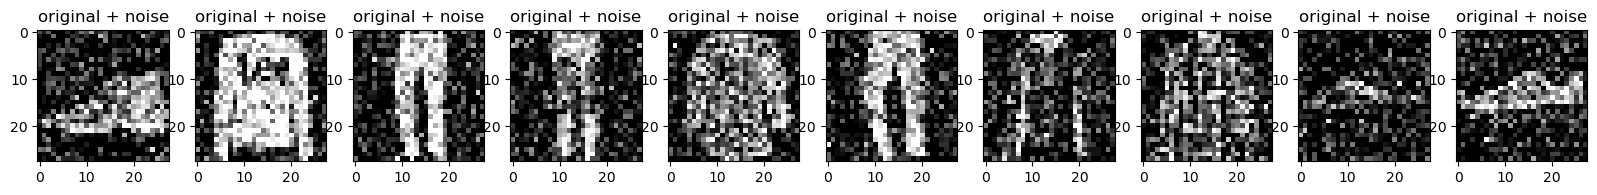

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [9]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 1)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [10]:
autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=30,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          verbose=1)

Epoch 1/30
1875/1875 [==============================] - 123s 62ms/step - loss: 0.0199 - val_loss: 0.0139
Epoch 2/30
1875/1875 [==============================] - 117s 62ms/step - loss: 0.0130 - val_loss: 0.0125
Epoch 3/30
1875/1875 [==============================] - 114s 61ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 4/30
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 5/30
1875/1875 [==============================] - 135s 72ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 6/30
1875/1875 [==============================] - 116s 62ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 7/30
1875/1875 [==============================] - 119s 64ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 8/30
1875/1875 [==============================] - 117s 62ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 9/30
1875/1875 [==============================] - 111s 59ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 10/30
1875/1875 [==============================] 

In [13]:
test_loss = autoencoder.evaluate(x_test_noisy, x_test)
print(f"Test Loss (Mean Squared Error): {test_loss}")

313/313 [==============================] - 4s 11ms/step - loss: 0.0101
Test Loss (Mean Squared Error): 0.010128689929842949


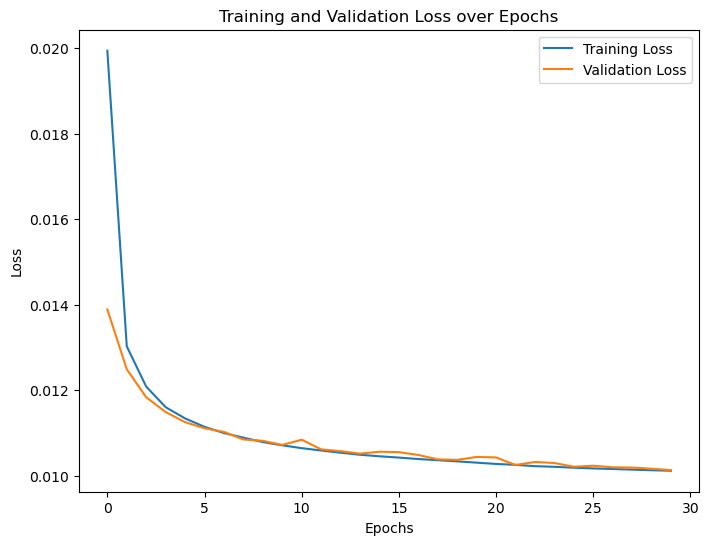

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

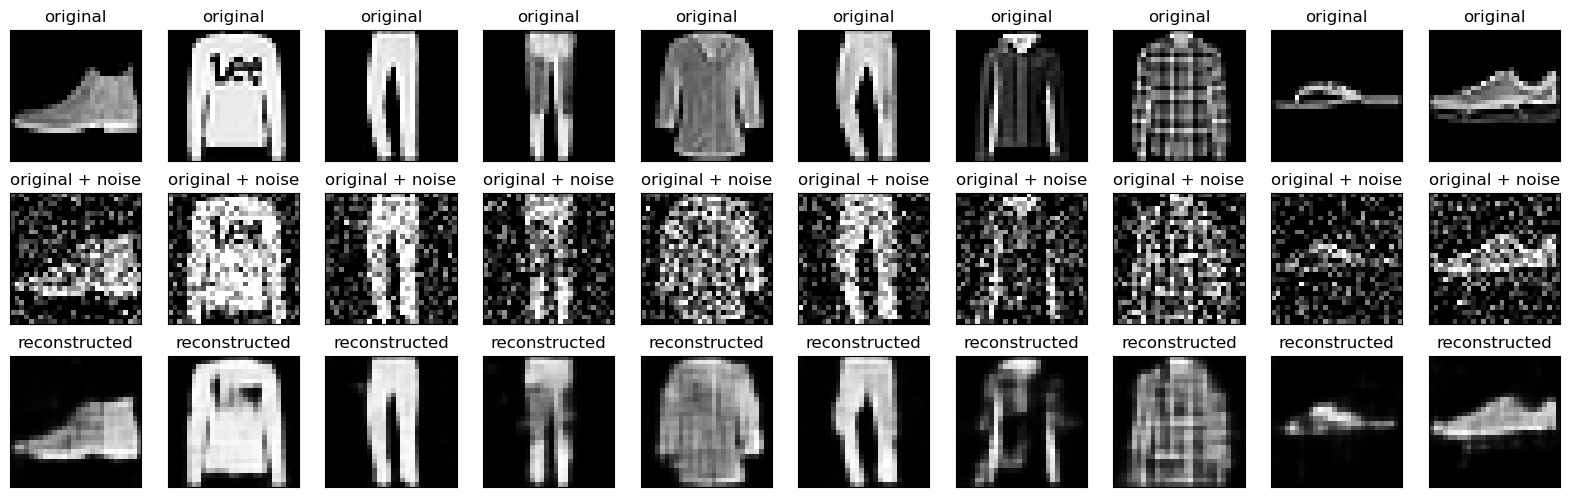

In [18]:
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()